In [5]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import ToTensor , Resize, Normalize, Compose, RandomHorizontalFlip, RandomRotation, RandomCrop
from torchmetrics.classification import MulticlassConfusionMatrix
import pandas as pd

In [4]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
data = CIFAR10("data", download=True)

In [7]:
data[0][0].size

(32, 32)

In [8]:
l_labels = []
for i in range(len(data)):
    if data[i][1] not in l_labels:
        l_labels.append(data[i][1])
print(len(l_labels), l_labels)        

10 [6, 9, 4, 1, 2, 7, 8, 3, 5, 0]


In [9]:
dict_labels = {
    0 : "самолет",
    1 : "машина",
    2: "птица",
    3 : "кошка",
    4 : "олень",
    5: "собака",
    6: "лягушка",
    7: "лошадь",
    8: "корабль",
    9: "грузовик"}

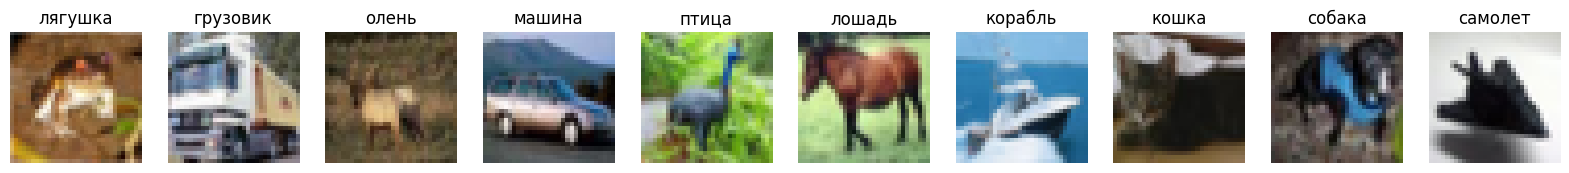

In [10]:
fig, axs = plt.subplots(1, 10, figsize = (20,5))
for i in range(len(l_labels)):
    for j in range(len(data)):
        if data[j][1]==l_labels[i]:
            axs.flat[i].imshow(data[j][0])
            axs.flat[i].axis("off")
            axs.flat[i].set_title(dict_labels[data[j][1]])
            break
       

In [11]:
mean_image_red_total,mean_image_green_total, mean_image_blue_total= 0,0,0
red_list, green_list, blue_list = [], [], []
for i in range(len(data)):
    transform = ToTensor()
    image = transform(data[i][0])
    red_list.extend(image[0])
    green_list.extend(image[1])
    blue_list.extend(image[2])
mean_red = round(np.array(red_list).flatten().mean(),4)
mean_green = round(np.array(green_list).flatten().mean(),4)
mean_blue = round(np.array(blue_list).flatten().mean(),4)
std_red = round(np.array(red_list).flatten().std(),4)
std_green = round(np.array(green_list).flatten().std(),4)
std_blue = round(np.array(blue_list).flatten().std(),4)
print(f"mean_red:{mean_red}, mean_green : {mean_green}, mean_blue: {mean_blue}")
print(f"std_red {std_red}, std_green: {std_green}, std_blue: {std_blue}")

mean_red:0.49140000343322754, mean_green : 0.4821999967098236, mean_blue: 0.4465000033378601
std_red 0.24699999392032623, std_green: 0.2434999942779541, std_blue: 0.26159998774528503


In [12]:
transform_train = Compose([
    RandomHorizontalFlip(p=0.5),
    RandomRotation(10),
    RandomCrop(size=32, padding=4),
    ToTensor(),
    Normalize([mean_red, mean_green, mean_blue], [std_red, std_green, std_blue])])

transform_test = Compose([
    ToTensor(),
    Normalize([mean_red, mean_green, mean_blue], [std_red, std_green, std_blue])])
    

train_data = CIFAR10("data", train = True, download=False, transform=transform_train)
test_data = CIFAR10("data", train = False, download=False, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=100, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=200, pin_memory=True)

In [13]:
len(train_data), len(test_data)

(50000, 10000)

In [59]:
all_matrix, all_acc_train, all_acc_test, all_loss_train, all_loss_test = [],[],[],[],[]
def trainAndTest(model, loss_f, train_loader, test_loader, optimizer, n_epochs):
    for epoch in range(n_epochs):
        model.train()
        correct = 0
        sum_loss = 0
        for step, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_f(output, target)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            pred = output.argmax(dim = 1)
            correct += pred.eq(target.view_as(pred)).sum().item()
        acc = correct/len(train_loader.dataset)
        avg_loss = sum_loss/len(train_loader)
        print(f"in epoch {epoch+1}  train_accuracy {acc: .4f}, avg_loss : {avg_loss: .4f}")
        all_acc_train.append(acc)
        all_loss_train.append(avg_loss)
    
        model.eval()
        correct = 0
        sum_loss = 0
        cm = MulticlassConfusionMatrix(num_classes=10).to(device)
        for step, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
                loss = loss_f(output, target)
                sum_loss += loss.item()
                pred = output.argmax(dim = 1)
                correct += pred.eq(target.view_as(pred)).sum().item()
                cm.update(pred, target)
        acc_test = correct/len(test_loader.dataset)
        avg_loss_test = sum_loss/len(test_loader)
        matrix=cm.compute()
        all_acc_test.append(acc_test)
        all_loss_test.append(avg_loss_test)
        all_matrix.append(matrix)
        print(f"test_accuracy {acc_test: .4f}, avg_loss_test : {avg_loss_test: .4f}")
    return(all_matrix, all_acc_train, all_acc_test, all_loss_train, all_loss_test)

In [43]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(in_features=1024*2*2, out_features=1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(in_features=1024,out_features=256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=n_classes)
        )

    def forward(self,x):

        return self.model(x)


In [44]:
model = CNN(10)
model = model.to(device)
n_epochs =35
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_f = nn.CrossEntropyLoss()

In [45]:
all_matrix, all_acc_train, all_acc_test, all_loss_train, all_loss_test=trainAndTest(model, loss_f, train_loader, test_loader, optimizer, n_epochs)
#test(model, test_loader, loss_f)

in epoch 1  train_accuracy  0.3067, avg_loss :  1.8146
test_accuracy  0.4084, avg_loss_test :  1.5588
in epoch 2  train_accuracy  0.4558, avg_loss :  1.4776
test_accuracy  0.5518, avg_loss_test :  1.2566
in epoch 3  train_accuracy  0.5518, avg_loss :  1.2758
test_accuracy  0.5858, avg_loss_test :  1.2307
in epoch 4  train_accuracy  0.6076, avg_loss :  1.1296
test_accuracy  0.6326, avg_loss_test :  1.0346
in epoch 5  train_accuracy  0.6492, avg_loss :  1.0191
test_accuracy  0.6734, avg_loss_test :  0.9589
in epoch 6  train_accuracy  0.6794, avg_loss :  0.9466
test_accuracy  0.7073, avg_loss_test :  0.8355
in epoch 7  train_accuracy  0.7072, avg_loss :  0.8737
test_accuracy  0.7658, avg_loss_test :  0.6882
in epoch 8  train_accuracy  0.7314, avg_loss :  0.8073
test_accuracy  0.7555, avg_loss_test :  0.7210
in epoch 9  train_accuracy  0.7504, avg_loss :  0.7502
test_accuracy  0.7771, avg_loss_test :  0.6474
in epoch 10  train_accuracy  0.7665, avg_loss :  0.7081
test_accuracy  0.7971, avg

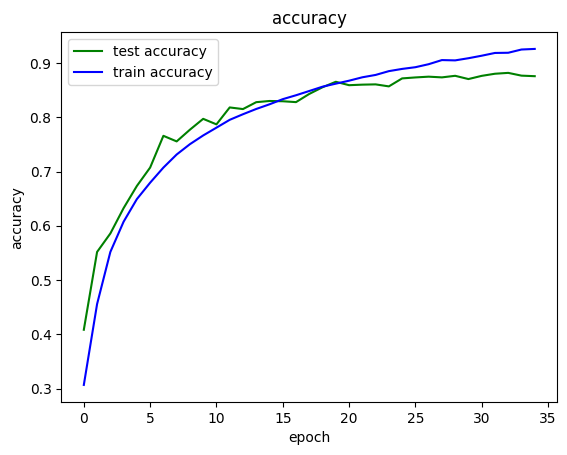

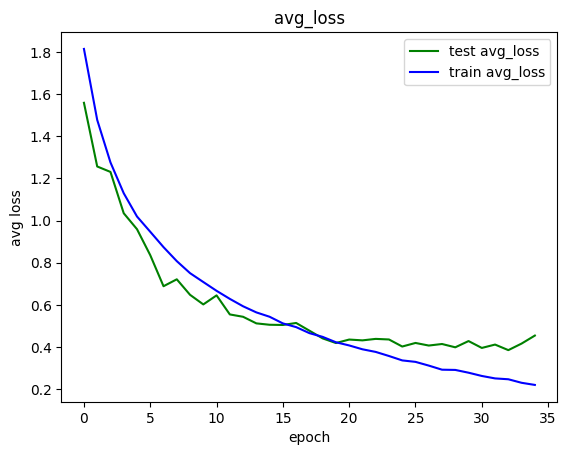

In [46]:

plt.plot(range(n_epochs), all_acc_test, color = "green", label = "test accuracy")
plt.plot(range(n_epochs), all_acc_train, color = "blue", label = "train accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("accuracy")
plt.show();
plt.plot(range(n_epochs), all_loss_test, color = "green", label = "test avg_loss")
plt.plot(range(n_epochs), all_loss_train, color = "blue", label = "train avg_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("avg loss")
plt.title("avg_loss")
plt.show();

In [52]:
all_matrix[-3]

tensor([[944,   4,  10,   8,   6,   0,   2,   2,  21,   3],
        [ 14, 907,   3,   0,   0,   5,   1,   2,  21,  47],
        [ 43,   0, 822,  39,  41,  21,  21,   9,   2,   2],
        [ 13,   1,  21, 794,  26,  85,  26,  21,   9,   4],
        [  9,   0,  30,  23, 891,  13,  13,  19,   2,   0],
        [  4,   1,  16, 109,  26, 820,   4,  18,   0,   2],
        [  9,   0,  29,  34,  14,   5, 904,   3,   1,   1],
        [ 17,   0,   8,  24,  24,  24,   1, 898,   2,   2],
        [ 45,   3,   5,   9,   1,   1,   1,   1, 926,   8],
        [ 34,  17,   6,   9,   0,   3,   0,   2,  17, 912]], device='cuda:0')

In [54]:
df = pd.DataFrame(all_matrix[-3].tolist(), index = [f"true_{dict_labels[n]}"  for n in range(len(dict_labels))], columns = [f"pred_{dict_labels[n]}"  for n in range(len(dict_labels))]).T
df

,true_самолет,true_машина,true_птица,true_кошка,true_олень,true_собака,true_лягушка,true_лошадь,true_корабль,true_грузовик
pred_самолет,944,14,43,13,9,4,9,17,45,34
pred_машина,4,907,0,1,0,1,0,0,3,17
pred_птица,10,3,822,21,30,16,29,8,5,6
pred_кошка,8,0,39,794,23,109,34,24,9,9
pred_олень,6,0,41,26,891,26,14,24,1,0
pred_собака,0,5,21,85,13,820,5,24,1,3
pred_лягушка,2,1,21,26,13,4,904,1,1,0
pred_лошадь,2,2,9,21,19,18,3,898,1,2
pred_корабль,21,21,2,9,2,0,1,2,926,17
pred_грузовик,3,47,2,4,0,2,1,2,8,912


In [55]:
max_errors, max_preds, max_true = 0,0,0
for column in df.columns.tolist():
    a= df[column].sort_values(ascending = False).index[1]
    b = df[column].sort_values(ascending = False).iloc[1]
    print(f" {column} чаще всего модель путала с {a} {b} раз")
    if b>max_errors:
        max_errors = b
        max_preds = a
        max_true = column
print(f"больше всего {max_errors} раз модель перепутала {max_true} с {max_preds}")        

 true_самолет чаще всего модель путала с pred_корабль 21 раз
 true_машина чаще всего модель путала с pred_грузовик 47 раз
 true_птица чаще всего модель путала с pred_самолет 43 раз
 true_кошка чаще всего модель путала с pred_собака 85 раз
 true_олень чаще всего модель путала с pred_птица 30 раз
 true_собака чаще всего модель путала с pred_кошка 109 раз
 true_лягушка чаще всего модель путала с pred_кошка 34 раз
 true_лошадь чаще всего модель путала с pred_кошка 24 раз
 true_корабль чаще всего модель путала с pred_самолет 45 раз
 true_грузовик чаще всего модель путала с pred_самолет 34 раз
больше всего 109 раз модель перепутала true_собака с pred_кошка


In [60]:
class CNN1(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Conv2d(in_channels = 20, out_channels=20, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(80),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=80, out_channels=120, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(120),
            nn.ReLU(),
            nn.Conv2d(in_channels=120, out_channels=150, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(150),
            nn.ReLU(),
            nn.Conv2d(in_channels=150, out_channels=200, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=200, out_channels=250, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(250),
            nn.ReLU(),
            nn.Conv2d(in_channels=250, out_channels=280, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(280),
            nn.ReLU(),
            nn.Conv2d(in_channels=280, out_channels=320, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(320),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=320, out_channels=400, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(400),
            nn.ReLU(),
            nn.Conv2d(in_channels=400, out_channels=500, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(500),
            nn.ReLU(),
            nn.Conv2d(in_channels=500, out_channels=600, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(600),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=600*1*1, out_features=1000),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=250),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(in_features=250, out_features=n_classes)
        )


    def forward(self, x):
        return self.model(x)


In [61]:
model_vgg = CNN1(10)
summary(model_vgg)

Layer (type:depth-idx)                   Param #
CNN1                                     --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       560
│    └─BatchNorm2d: 2-2                  40
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       3,620
│    └─BatchNorm2d: 2-5                  40
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─Conv2d: 2-8                       7,240
│    └─BatchNorm2d: 2-9                  80
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      28,880
│    └─BatchNorm2d: 2-12                 160
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
│    └─Conv2d: 2-15                      86,520
│    └─BatchNorm2d: 2-16                 240
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      162,150
│    └─BatchNorm2d: 2-19                 300
│   

In [62]:
model_vgg = model_vgg.to(device)
n_epochs1 = 45
optimizer1 = torch.optim.Adam(model_vgg.parameters(), lr = 1e-3)
loss_f = nn.CrossEntropyLoss()

In [63]:
all_matrix, all_acc_train, all_acc_test, all_loss_train, all_loss_test=trainAndTest(model_vgg, loss_f, train_loader, test_loader, optimizer1, n_epochs1)
#test(model_vgg, test_loader, loss_f)

in epoch 1  train_accuracy  0.2077, avg_loss :  1.9323
test_accuracy  0.2418, avg_loss_test :  1.8640
in epoch 2  train_accuracy  0.3027, avg_loss :  1.7299
test_accuracy  0.3201, avg_loss_test :  1.8695
in epoch 3  train_accuracy  0.4100, avg_loss :  1.5213
test_accuracy  0.4542, avg_loss_test :  1.4013
in epoch 4  train_accuracy  0.4997, avg_loss :  1.3496
test_accuracy  0.5794, avg_loss_test :  1.1262
in epoch 5  train_accuracy  0.5733, avg_loss :  1.1873
test_accuracy  0.5961, avg_loss_test :  1.0945
in epoch 6  train_accuracy  0.6189, avg_loss :  1.0853
test_accuracy  0.6688, avg_loss_test :  0.9869
in epoch 7  train_accuracy  0.6592, avg_loss :  0.9903
test_accuracy  0.6958, avg_loss_test :  0.8766
in epoch 8  train_accuracy  0.6857, avg_loss :  0.9278
test_accuracy  0.7071, avg_loss_test :  0.8296
in epoch 9  train_accuracy  0.7066, avg_loss :  0.8760
test_accuracy  0.7243, avg_loss_test :  0.8191
in epoch 10  train_accuracy  0.7231, avg_loss :  0.8310
test_accuracy  0.7413, avg

In [ ]:
plt.plot(range(n_epochs), all_acc_test, color = "green", label = "test accuracy")
plt.plot(range(n_epochs), all_acc_train, color = "blue", label = "train accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("accuracy")
plt.show();
plt.plot(range(n_epochs), all_loss_test, color = "green", label = "test avg_loss")
plt.plot(range(n_epochs), all_loss_train, color = "blue", label = "train avg_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("avg loss")
plt.title("avg_loss")
plt.show();

Text(0.5, 1.0, 'avg_loss')

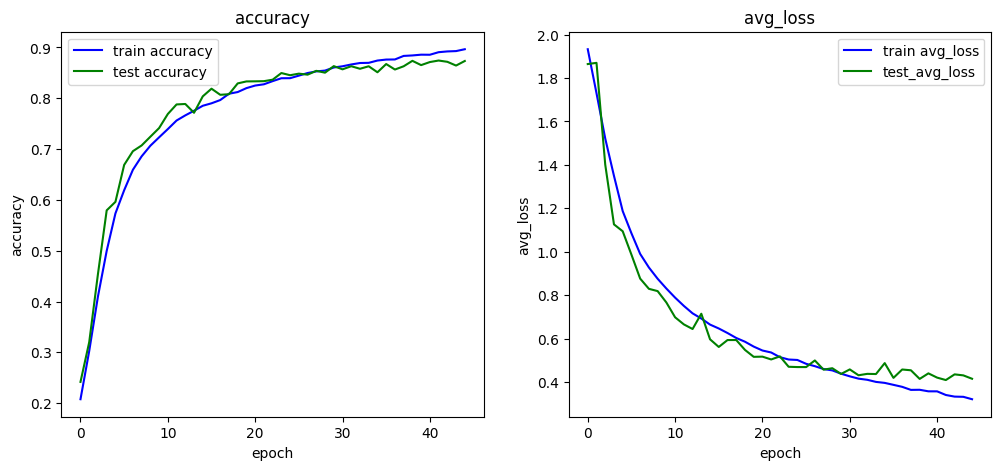

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.plot(range(n_epochs1), all_acc_train, color = "blue", label = "train accuracy")
ax1.plot(range(n_epochs1), all_acc_test, color = "green", label = "test accuracy")
ax1.legend()
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")
ax1.set_title("accuracy")

ax2.plot(range(n_epochs1), all_loss_train, color = "blue", label = "train avg_loss")
ax2.plot(range(n_epochs1), all_loss_test, color = "green", label = "test_avg_loss")
ax2.legend()
ax2.set_xlabel("epoch")
ax2.set_ylabel("avg_loss")
ax2.set_title("avg_loss")